In [1]:
import os # for file handling
import pathlib # for reading files
import pandas as pd # for reading csv files
import numpy as np # for numerical operations
from PIL import Image # for opening images
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf # for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall
from tensorflow.keras.regularizers import l2

Check GPU

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

## Load Data using Keras utility

In [2]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_hsr_training_2024_06_06\\training')

We have 3 cats but recently a fourth cat is showing up. Since we have only few imaes of this cat let's ignore this for now and train only for our own 3 cats.

Define parameters for loader

In [3]:
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.

img_height = 240 # Using the actual sizes takes too long for training. Grösse halbiert.
img_width = 320

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3540 files belonging to 3 classes.
Using 2832 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3540 files belonging to 3 classes.
Using 708 files for validation.


By default, if label_mode is not specified, it is set to "int", which means the function automatically assigns an integer label to each class. Classes are usually indexed according to the alphanumeric order of the folder names. Therefore, each image is labeled with the integer representing its class index.

'h' -> 0

'o' -> 1

'r' -> 2

's' -> 3

SparseCategoricalCrossentropy the appropriate choice for the loss function because it expects the labels to be provided as integers

You can find the class names in the `class_names` attribute on these datasets.

In [6]:
class_names = train_ds.class_names
print(class_names)

['h', 'r', 's']


## visualize the Data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

An image can be represented as a 3-D tensor. For a color image, the dimensions might correspond to height, width, and color channels (RGB). The `image_batch` is a tensor of the shape `(32, 480, 640, 3)`. This is a batch of 32 images of shape `480x640x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
# not neccessary if it is included as the first layer in the model
# normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
'''
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''

Or, you can include the layer inside your model definition to simplify deployment. Use the second approach here.

# A basic Keras model

The `softmax` function is particularly suited for multi-class classification problems where each class is mutually exclusive.

When using `softmax`, set `from_logits=False`

When not using `softmax` (last layer outputs raw scores), set `from_logits=True` 

### Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [ ]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dense(num_classes, activation='softmax') # Using softmax for probability output
])

Padding = same

Enhanced Edge Learning: In the context of cat images, distinguishing features such as the tips of ears, whiskers, or patterns on the fur near the edges could be crucial for accurate classification. Padding ensures that convolutions applied to the edges of an image don't shrink the spatial dimension, thus better preserving the information at the edges.

Consider a scenario where your images of cats vary slightly in where the cats are positioned within the image frame. Without appropriate padding, important features at the edges might get progressively omitted in deeper layers, potentially leading to poorer model performance, especially if those edge features are critical for distinguishing between similar cat breeds.

### Compile the model

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
# set from_logits=True if the model does not include a softmax activation
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

When using `from_logits=True` the last layer should not apply softmax (it outputs raw scores)
When using `from_logits=False`, the last layer should apply softmax to output probabilities.

In [ ]:
model.summary()

### Train model

In [ ]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Total overfit! The plots show that training accuracy and validation accuracy are off by large margins.

## Try on example data

In [ ]:
# Directory containing your test images
directory = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test'

# Load class names
class_names = ['h', 'r', 's']  # This should be the same as `train_ds.class_names`

# Iterate over each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):  # check for image files
        # Load the image
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)#.convert('RGB')

        # Convert image to array (no need to normalize)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # model expects batch of images

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)  # get the class index

        # Print the filename and predicted class name
        print(f"{filename}: Class {class_names[predicted_class[0]]}")

    else:
        continue

Results are not accurate at all. The class r is never assigned. This could be because the model is overfitting and because the class r is underrepresented. 

# Adding Dropout Layer

`CategoricalAccuracy` vs `SparseCategoricalAccuracy`:

If labels are integer-encoded (like 0, 1, 2, 3 for four classes), use `SparseCategoricalAccuracy` and `SparseCategoricalCrossentropy`.
If labels are one-hot encoded (like [1, 0, 0, 0] for class 0), then use `CategoricalAccuracy` and `CategoricalCrossentropy`

In [ ]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),  # Dropout after pooling
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
  layers.Dropout(0.5),  # Higher dropout before the final layers
  layers.Dense(num_classes, activation='softmax') # Using softmax for probability output
])

'''
model = Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])
'''

Input Layer: Takes in your images, which should be formatted to the expected dimensions (height x width x channels). The input images are also normalized or scaled, often to a range between 0 and 1.

Convolutional Layers (Conv2D): These layers apply filters to the input images to create feature maps. They extract important features from the images, such as edges, textures, or more complex patterns in deeper layers.

Pooling Layers (MaxPooling2D): Reduce the spatial dimensions (width, height) of the input volume for the next convolutional layer. They help make the detection of features somewhat invariant to scale and orientation changes.

Dropout Layers: Randomly drop units (and their connections) during training time to prevent overfitting by providing a form of regularization.

Flatten Layer: Converts the 2D feature maps into a 1D feature vector. Necessary to transition from the convolutional layers to fully connected layers.

Dense Layers: Fully connected layers that learn non-linear combinations of the high-level features extracted by the convolutional layers.

Output Layer: A dense layer with a softmax activation function that outputs the probability distribution across the classes.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Use 'sparse_categorical_crossentropy' if labels are integers
  metrics='accuracy')

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [ ]:
model.summary()

In [ ]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(171) # adjust this based on the number of epochs trained for (to avoid value error)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test on Example data

In [ ]:
# Directory containing your test images
directory = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test'

# Load class names
class_names = ['h', 'r', 's']  # This should be the same as `train_ds.class_names`

# Iterate over each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):  # check for image files
        # Load the image
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)#.convert('RGB')

        # Resize the image to match the input size expected by the model
        img = img.resize((img_width, img_height))

        # Convert image to array (no need to normalize)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # model expects batch of images

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)  # get the class index

        # Print the filename and predicted class name
        print(f"{filename}: Class {class_names[predicted_class[0]]}")

    else:
        continue

It is already better, as the r class is considered at least. Accuracy is not that good, though. Together with inspecting the low training accuracy compared to the higher validation accuracy, I think that the model is underfitting. Let's add some more layers to the model...

# Add more Convolutional Layers

In [ ]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Use 'sparse_categorical_crossentropy' if labels are integers
  metrics='accuracy')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

In [ ]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(68) # adjust this based on the number of epochs trained for (to avoid value error)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test on example data

In [ ]:
# Directory containing your test images
directory = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test'

# Load class names
class_names = ['h', 'r', 's']  # This should be the same as `train_ds.class_names`

# Iterate over each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):  # check for image files
        # Load the image
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)#.convert('RGB')

        # Resize the image to match the input size expected by the model
        img = img.resize((img_width, img_height))

        # Convert image to array (no need to normalize)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # model expects batch of images

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)  # get the class index

        # Print the filename and predicted class name
        print(f"{filename}: Class {class_names[predicted_class[0]]}")

    else:
        continue

Results hare still not overwhelmingly accurate. The training and validation accuracy curves do not look bad, though. It seems that the underrepresented categorey still makes problems. 

# Add Batch Normalization

In [8]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

# filter size and pool_size are set to 3x3 and 2x2 respectively (may be the default anyway)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

Number of classes: 3


In [9]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Use 'sparse_categorical_crossentropy' if labels are integers
  metrics='accuracy')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 320, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 240, 320, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 160, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 120, 160, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 64)      1

In [10]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
89/89 [==============================] - 8s 47ms/step - loss: 3.5450 - accuracy: 0.6529 - val_loss: 11.5685 - val_accuracy: 0.4308 - lr: 0.0010
Epoch 2/500
89/89 [==============================] - 4s 41ms/step - loss: 2.0480 - accuracy: 0.7341 - val_loss: 3.0147 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 3/500
89/89 [==============================] - 4s 41ms/step - loss: 1.7175 - accuracy: 0.7461 - val_loss: 3.0139 - val_accuracy: 0.3715 - lr: 0.0010
Epoch 4/500
89/89 [==============================] - 4s 41ms/step - loss: 1.7529 - accuracy: 0.7528 - val_loss: 2.4795 - val_accuracy: 0.4477 - lr: 0.0010
Epoch 5/500
89/89 [==============================] - 4s 40ms/step - loss: 1.5093 - accuracy: 0.7680 - val_loss: 2.2616 - val_accuracy: 0.4534 - lr: 0.0010
Epoch 6/500
89/89 [==============================] - 4s 41ms/step - loss: 1.6226 - accuracy: 0.7768 - val_loss: 1.8903 - val_accuracy: 0.5819 - lr: 0.0010
Epoch 7/500
89/89 [==============================] - 4s 41ms/step - l

over 4min training time with GPU

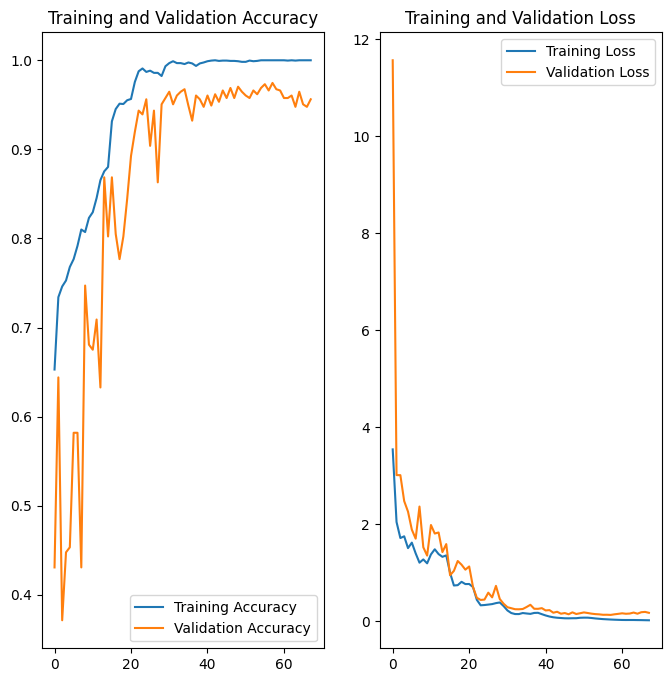

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(68) # adjust this based on the number of epochs trained for (to avoid value error)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Directory containing your test images
directory = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test'

# Load class names
class_names = ['h', 'r', 's']  # This should be the same as `train_ds.class_names`

# Iterate over each image in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):  # check for image files
        # Load the image
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)#.convert('RGB')

        # Resize the image to match the input size expected by the model
        img = img.resize((img_width, img_height))

        # Convert image to array (no need to normalize)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # model expects batch of images

        # Predict the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)  # get the class index

        # Print the filename and predicted class name
        print(f"{filename}: Class {class_names[predicted_class[0]]}")

    else:
        continue

1/1 [==============================] - 0s 241ms/step
approach_Hali.jpg: Class h
1/1 [==============================] - 0s 12ms/step
approach_Hali2.jpg: Class h
1/1 [==============================] - 0s 11ms/step
approach_Hali3.jpg: Class h
1/1 [==============================] - 0s 12ms/step
approach_other.jpg: Class s
1/1 [==============================] - 0s 10ms/step
approach_Rex.jpg: Class r
1/1 [==============================] - 0s 12ms/step
approach_Rex2.jpg: Class r
1/1 [==============================] - 0s 13ms/step
approach_Rex3.jpg: Class r
1/1 [==============================] - 0s 10ms/step
approach_Simba.jpg: Class s
1/1 [==============================] - 0s 12ms/step
approach_SimbaHali.jpg: Class r
1/1 [==============================] - 0s 11ms/step
noapproach_.jpg: Class r
1/1 [==============================] - 0s 11ms/step
noapproach_Hali.jpg: Class h
1/1 [==============================] - 0s 12ms/step
noapproach_Hali2.jpg: Class h
1/1 [==============================] - 0

So far this is the best result. Simba once got classified as Hali and the only other errors we get are related to class r, which is the underrepresented class. Seems like we don't get around the data augmentation part...

### test out pipeline for model inference

In [21]:
import keras
from PIL import Image # for opening images
import numpy as np # for numerical operations

#load model "models/best_model_hsr3.h5"
model = keras.models.load_model("C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\models\\best_model_hsr3.h5")

# define image size
img_height = 240
img_width = 320

img = Image.open("C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test\\approach_Hali2.jpg")
img = img.resize((img_width, img_height))

# Convert image to array (no need to normalize)
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # model expects batch of images

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)  # get the class index

class_names = ['h', 'r', 's']
#print(f"Class {class_names[predicted_class[0]]}")
cat = class_names[predicted_class[0]]
if cat == 'h':
    print("Hali")
elif cat == 'r':
    print("Rexxu")
elif cat == 's':
    print("Simbi")
else:
    print("Unbekannte Katze")


1/1 [==============================] - 0s 55ms/step
Hali
